# Joint embedding of annotated osteosarcoma datasets using EmbedMNN model

In this example, we will use **transmorph** to integrate a challenging osteosarcoma databank from 11 patients, gathered in [1], with the help of annotations. These datasets contain in total more than 60,000 cells, which are all associated with a cell type annotation. This data bank is challenging for several reasons: large number of batches and cell types, high number of cells, many batches missing some cell types. 

We use one of our built-in models, EmbedMNN, to carry out the integration. It combines a few preprocessing steps (common genes space embedding, normalization and dimensionality reduction) with a mutual nearest neighbors (MNN)-based matching [2] and a low-dimensional space embedding using UMAP [3] or MDE [4]. This low dimensional space can subsequently be used to carry out tasks such as clustering. This is a schematic view of EmbedMNN architecture.

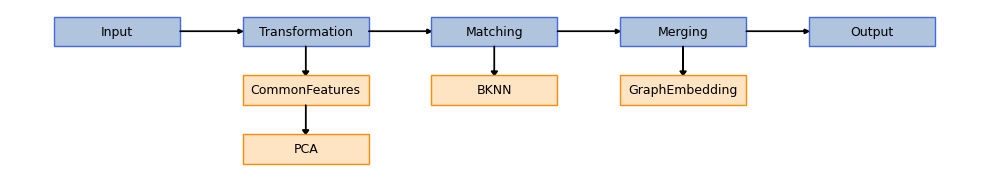

In [1]:
from transmorph.models import EmbedMNN
from transmorph.utils.plotting import plot_model

model = EmbedMNN(obs_class="class_type") 
plot_model(model)

### Loading the data bank

**transmorph** provides a few data banks for testing purposes, already preprocessed (cell/gene filtering, normalization, log1p...) and annotated. They can be loaded using *datasets* module. Osteosarcoma databank contains 11 annotated datasets in the AnnData format, each expressed within its 10,000 most variable genes space. Cells are annotated by the .obs key "class_typr". If the queried databank is missing, it will be automatically downloaded, and saved locally for faster subsequent access.

In [2]:
from transmorph.datasets import load_zhou_10x

# Format: {patient_label -> AnnData}
zhou_10x = load_zhou_10x()

databank_api > Loading bank zhou_10x.
databank_api > Bank zhou_10x successfully loaded.


We can first call a transmorph description function to have a closer look at our databank, providing the .obs key containing cell annotations, "class". We can then observe dataset and annotation distribution across our databank.

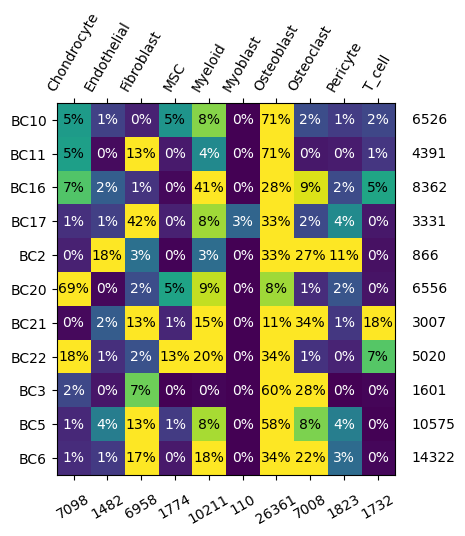

In [3]:
# Displaying cell type distribution across batches

from transmorph.utils.plotting import plot_label_distribution_heatmap

plot_label_distribution_heatmap(zhou_10x, label="class_type")

### Plotting initial datasets with scatter_plot

The scatter_plot method can be used to display a low dimensional representation of a set of datasets. It will automatically use a transmorph integrated representation if present in all AnnData objects. If this integrated representation is missing, it will try to compute a UMAP of .X matrices. Computing this UMAP representation can take some time for large datasets, but it only needs to be computed once.

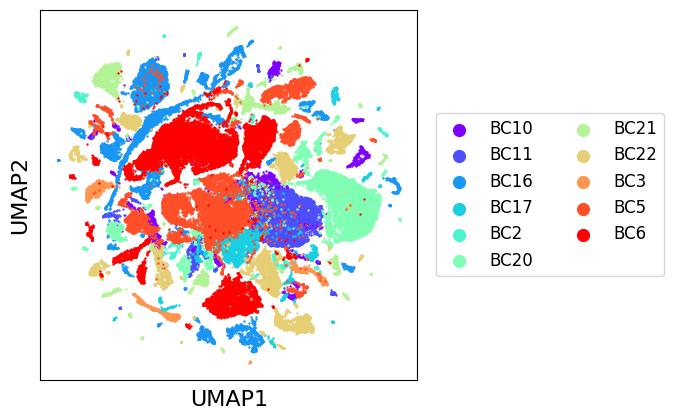

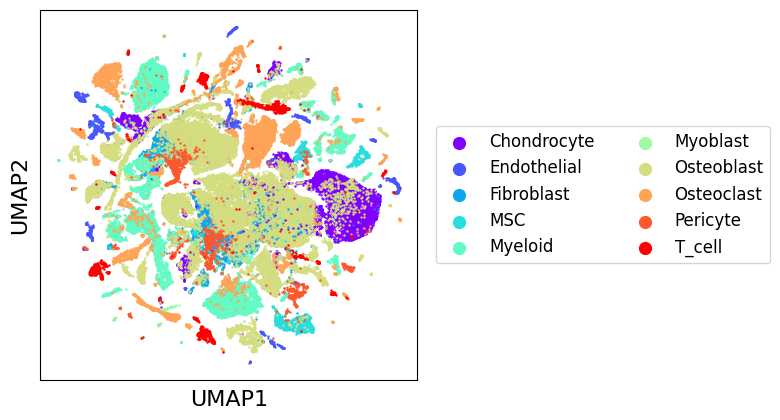

In [4]:
from transmorph.utils.plotting import scatter_plot, reduce_dimension

reduce_dimension(zhou_10x, output_obsm="tr_umap")

scatter_plot(zhou_10x, use_rep="tr_umap")
scatter_plot(zhou_10x, color_by="class_type", use_rep="tr_umap")

As we can see, there seems to be a general natural clustering of cell types. Though, we observe very important variations between batches, that EmbedMNN will aim to correct. 

### Assessing mixing using LISI

We can assess integration quality using LISI introduced with Harmony [4], which gives an estimation of the number of different labels in the neighborhood of a cell. We use "LISI-batch" with batches as labels to evaluate mixing (higher is better mixed), and "LISI-class" with cell types as labels to evaluate cell types separation (lower is more pure).

In [5]:
from transmorph.stats.lisi import lisi

datasets = list(zhou_10x.values())
lisi_batch_bef = lisi(datasets, obsm="tr_umap") # By default, gene representation is used
lisi_class_bef = lisi(datasets, obsm="tr_umap", obs="class_type")

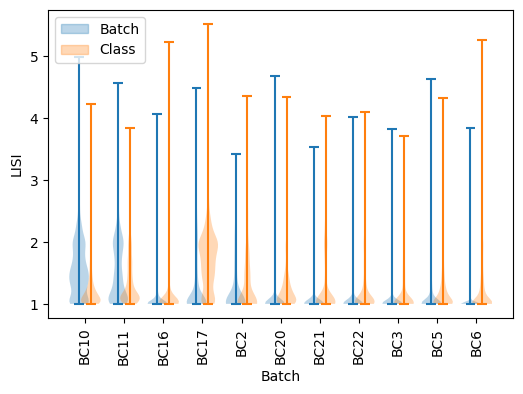

In [6]:
# Plotting LISI as violin plots

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))
    
positions = np.arange(len(datasets))

labels = []
plt.figure(figsize=(6,4))
add_label(plt.violinplot(lisi_batch_bef, positions=positions - .15), "Batch")
add_label(plt.violinplot(lisi_class_bef, positions=positions + .15), "Class")
plt.xticks(positions, zhou_10x.keys(), rotation=90)
plt.xlabel("Batch")
plt.ylabel("LISI")

plt.legend(*zip(*labels), loc=2)
pass

As we can see, except for P10 all batches have only same-batches cells in their neighborhood except BC11 and BC17, and cell type purity is quite decent except for BC17. The goal of integration is to increase LISI-batch while keeping LISI-class as low as possible.

### Dataset integration using EmbedMNN

**EmbedMNN** combines a mutual nearest neighbors step with a graph embedding using UMAP. Parameters can be tuned during model instanciation. Model can then be ran using transform() method, providing a list of AnnData objects and a reference AnnData. The method will add a .obsm["transmorph"] entry, corresponding to the integrated view computed. We provided annotations contained in the *.obs* "class_type" to improve matching quality, consequently improving final embedding.
**This model embeds all datasets in a common genes space, therefore there must exists a nonempty intersection between all .var_names.**

In [7]:
model.transform(zhou_10x)

EMBED_MNN > Transmorph model is initializing.
EMBED_MNN > Ready to start the integration of 11 datasets, 64557 total samples.
EMBED_MNN > Running layer LAYER_INPUT#0.
EMBED_MNN > Running layer LAYER_TRANSFORMATION#1.
EMBED_MNN > Running layer LAYER_MATCHING#2.
LAYER_MATCHING#2 > Calling matching MATCHING_MNN.
EMBED_MNN > Running layer LAYER_MERGING#3.
LAYER_MERGING#3 > Running merging MERGING_GRAPH_EMBEDDING...
EMBED_MNN > Running layer LAYER_OUTPUT#4.
EMBED_MNN > Terminated. Total embedding shape: (64557, 2)
EMBED_MNN > Results have been written in AnnData.obsm['transmorph'].


### Integration analysis with LISI

We can then have a look at the final embedding, stored in the *.obsm* field "transmorph". It can be passed as input to scatter_plot function.

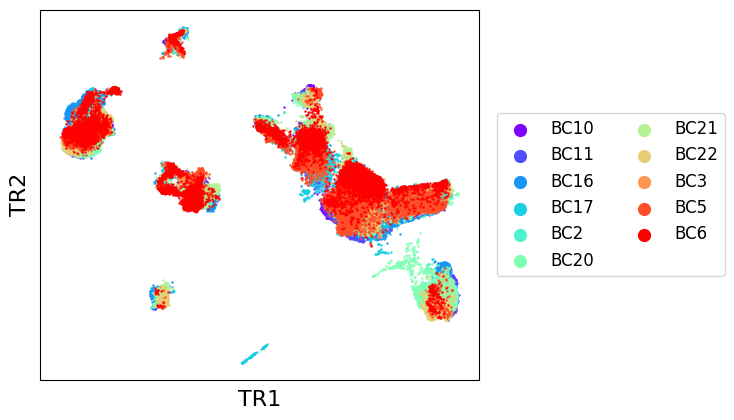

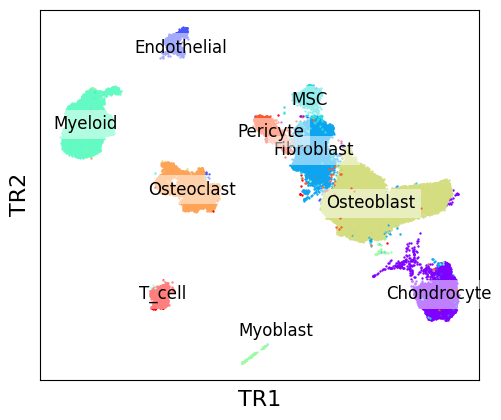

In [8]:
from transmorph.utils.plotting import scatter_plot

scatter_plot(zhou_10x, use_rep="transmorph", xlabel="TR1", ylabel="TR2")
scatter_plot(zhou_10x, use_rep="transmorph",xlabel="TR1", ylabel="TR2", color_by="class_type", labels_on_plot=True)

As we can see, EmbedMNN seems to have greatly improved the mixing between batches, while reasonably conserving distinction between cell types. We can confirm this by comparing with post-transmorph LISI.

In [9]:
from transmorph.stats.lisi import lisi

datasets = list(zhou_10x.values())
lisi_batch_aft = lisi(datasets, obsm="transmorph")
lisi_class_aft = lisi(datasets, obsm="transmorph", obs="class_type")

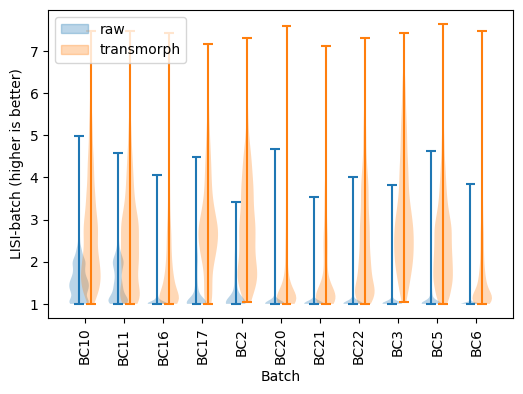

In [10]:
# LISI-batch (higher is better)
labels = []
plt.figure(figsize=(6,4))
add_label(plt.violinplot(lisi_batch_bef, positions=positions - .15), "raw")
add_label(plt.violinplot(lisi_batch_aft, positions=positions + .15), "transmorph")
plt.xticks(positions, zhou_10x.keys(), rotation=90)
plt.xlabel("Batch")
plt.ylabel("LISI-batch (higher is better)")

plt.legend(*zip(*labels), loc=2)
pass

LISI-batch has greatly improved using transmorph, meaning batches are now way better mixed.

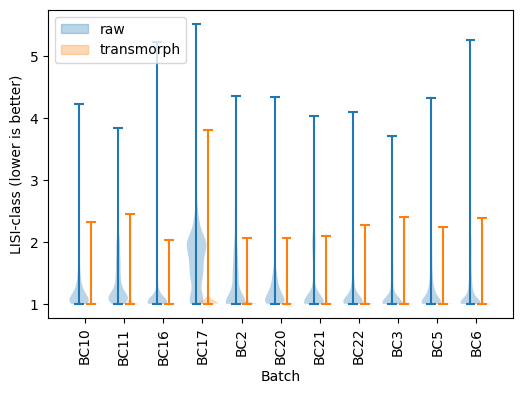

In [11]:
# LISI-class (lower is better)
labels = []
plt.figure(figsize=(6,4))
add_label(plt.violinplot(lisi_class_bef, positions=positions - .15), "raw")
add_label(plt.violinplot(lisi_class_aft, positions=positions + .15), "transmorph")
plt.xticks(positions, zhou_10x.keys(), rotation=90)
plt.xlabel("Batch")
plt.ylabel("LISI-class (lower is better)")

plt.legend(*zip(*labels), loc=2)
pass

LISI-class has also consistently decreased using transmorph, meaning cell types are better separated.

## References

[1] Zhou, Yan, et al. *Single-cell RNA landscape of intratumoral heterogeneity and immunosuppressive microenvironment in advanced osteosarcoma.* **Nature communications** 11.1 (2020): 1-17.

[2] Haghverdi, Laleh, et al. *Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.* **Nature biotechnology** 36.5 (2018): 421-427.

[3] Becht, Etienne, et al. *Dimensionality reduction for visualizing single-cell data using UMAP.* **Nature biotechnology** 37.1 (2019): 38-44.

[4]  Korsunsky, Ilya, et al. *Fast, sensitive and accurate integration of single-cell data with Harmony.* **Nature methods** 16.12 (2019): 1289-1296.
